# Inspecting Data 

In [5]:
import rasterio
import numpy as np
from rasterio.plot import adjust_band
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show
from rasterio.windows import Window
from pyproj import Proj, transform

In [1]:
def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

In [6]:
file_len("rcnn/test_px.txt")

2570

## First let's inspect our labeled landcover dataset

In [6]:
# Open our raster dataset
label_dataset = rasterio.open('/deep_data/landcover_reproject.tif')
label_image = label_dataset.read()

# How many bands does this image have?
num_bands = label_dataset.count
print('Number of bands in image: {n}\n'.format(n=num_bands))

# How many rows and columns?
rows, cols = label_dataset.shape
print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))

# What driver was used to open the raster?
driver = label_dataset.driver
print('Raster driver: {d}\n'.format(d=driver))

# What is the raster's projection?
proj = label_dataset.crs
print('Image projection:')
print(proj)

Number of bands in image: 1

Image size is: 17107 rows x 21332 columns

Raster driver: GTiff

Image projection:
EPSG:32618


### What is the pixel size?

In [3]:
gt = label_dataset.transform
print(gt)

| 30.00, 0.00,-130215.00|
| 0.00,-30.00, 4187595.00|
| 0.00, 0.00, 1.00|


In [4]:
pixelSizeX = gt[0]
pixelSizeY =-gt[4]

print(pixelSizeX)
print(pixelSizeY)

30.0
30.0


#### What is the image shape?

In [5]:
label_image.shape

(1, 17107, 21332)

#### how many classes are there?

In [6]:
np.unique(label_image)

KeyboardInterrupt: 

#### For now I'm just combining all pixels currently classified as 255 into class 1

But it might be worth combining other classes here too and saving out the raster as something new


In [ ]:
label_image[label_image == 255] = 1

Let's take a look at it

In [ ]:
fig, ax = plt.subplots(figsize=[15,15])
ax.imshow(label_image[0,:,:])

Since that isn't very informative let's add a colormap and visualize what's really there

In [ ]:
# next setup a colormap for our map
colors = dict((
    (11, (0,0,255)),
(12, (0,0,255)),
(21, (0,0,255)),
(22, (0,0,255)),
(23, (0,0,255)),
(24, (0,0,255)),
(31, (0,0,255)),
(41, (0,0,255)),
(42, (0,0,255)),
(43, (0,0,255)),
(52, (0,0,255)),
(71, (0,0,255)),
(81, (0,0,255)),
(82, (0,0,255)),
(90, (0,0,255)),
(95, (0,0,255)),
))

n = int(np.max(label_image))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(0, n)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n)

# Now show the class map next to the RGB image

fig, axs = plt.subplots(figsize=(15,15))

axs.imshow(label_image[0,:, :], cmap=cmap, interpolation='none')
#axs.imshow(image[0,:, :], cmap=cmap, interpolation='none')

plt.show()

NameError: name 'show_hist' is not defined

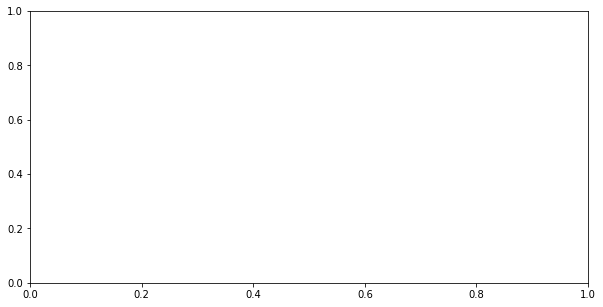

In [7]:
fig, ax = plt.subplots(figsize=(10,5))
show_hist(label_dataset, ax=ax, bins=len(np.unique(label_image)), lw=0.0, stacked=False, 
               histtype='stepfilled', title="Class Distribution")

In [ ]:
label_dataset.close()

## Moving to Landsat Inspection

In [ ]:
image_index = 4

In [ ]:
l8_image_paths = [
    '/deep_data/processed_landsat/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined.tif',
    '/deep_data/processed_landsat/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined.tif',  
    '/deep_data/processed_landsat/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined.tif',
    '/deep_data/processed_landsat/LC08_CU_028012_20171103_20190429_C01_V01_SR_combined.tif',
    '/deep_data/processed_landsat/LC08_CU_029011_20171018_20190429_C01_V01_SR_combined.tif',
]
l8_filename = l8_image_paths[image_index]

In [ ]:
#l8_filename = '/deep_data/processed_landsat/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined.tif'

image_dataset = rasterio.open(l8_filename)

# How many bands does this image have?
num_bands = image_dataset.count
print('Number of bands in image: {n}\n'.format(n=num_bands))

# How many rows and columns?
rows, cols = image_dataset.shape
print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))

# What driver was used to open the raster?
driver = image_dataset.driver
print('Raster driver: {d}\n'.format(d=driver))

# What is the raster's projection?
proj = image_dataset.crs
print('Image projection:')
print(proj)


#### Let's just visualize it to see what's going on

In [ ]:
import matplotlib.pyplot as plt
from rasterio.plot import show_hist

full_img = image_dataset.read()
clipped_img = full_img[[3, 2, 1], :, :]
print(clipped_img.shape)
fig, ax = plt.subplots(figsize=(10,7))
show(clipped_img[:, :, :], ax=ax, transform=image_dataset.transform) # add the transform arg to get it in lat long coords

#### Not very informative...

Let's try to normalize it with the built in rasterio adjust_band function

In [ ]:
from rasterio.plot import adjust_band, show_hist

img_norm = adjust_band(clipped_img) # normalize bands to range between 1.0 to 0.0
img_reshaped = reshape_as_image(img_norm) # reshape to [rows, cols, bands]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# the rasterio show function takes in [bands, rows, cols] so we don't need to reshape
show(img_norm, ax=axs[0])
axs[0].set_title("RGB from rasterio show")

# plot with normal matplotlib functions
axs[1].imshow(img_reshaped)
axs[1].set_title("RGB in matplotlib imshow")

Still not very useful, let's check out the historgram and normalize it ourselves

In [ ]:
print(np.amax(full_img))
print(np.amin(full_img))

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
show_hist(image_dataset, ax=ax, bins=50, lw=0.0, stacked=False, alpha=0.3, 
               histtype='stepfilled', title="Full Histogram")

In [ ]:
from rasterio.plot import reshape_as_raster, reshape_as_image

# Extract reference to SWIR1, NIR, and Red bands
index = np.array([3, 2, 1])
colors = full_img[index, :, :].astype(np.float64)

max_val = 4000
min_val = 0

# Enforce maximum and minimum values
colors[colors[:, :, :] > max_val] = max_val
colors[colors[:, :, :] < min_val] = min_val

for b in range(colors.shape[0]):
    colors[b, :, :] = colors[b, :, :] * 1 / (max_val - min_val)

# rasters are in the format [bands, rows, cols] whereas images are typically [rows, cols, bands]
# and so our array needs to be reshaped
print(colors.shape)
colors_reshaped = reshape_as_image(colors)
print(colors_reshaped.shape)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# plot with normal matplotlib functions
ax.imshow(colors_reshaped)
ax.set_title("RGB in matplotlib imshow")

### okay that's what it should really look like!

In [ ]:
#### now let's check out the quality band
clipped_img = full_img[[7], :, :]
print(clipped_img.shape)
fig, ax = plt.subplots(figsize=(10,7))
show(clipped_img[:, :, :], ax=ax, transform=image_dataset.transform)
# show(clipped_img[:, :, :], ax=ax, transform=image_dataset.transform) # add the transform arg to get it in lat long coords

Looks good too!

### Now let's inspect where it is on the map

In [ ]:
from pyproj import transform
# this will get our four corner points
raster_utm_points = image_dataset.transform * (0, 0), image_dataset.transform * (image_dataset.width, 0), image_dataset.transform * (image_dataset.width, image_dataset.height), image_dataset.transform * (0, image_dataset.height)

# Project all longitudes, latitudes using the pyproj package
p1 = Proj(image_dataset.crs) # our current crs
p2 = Proj("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs ") # the crs we want our raster to be in

# use the pyproj.transform function to convert the positions to longs, lats
lats, longs = transform(p1, p2, np.array(raster_utm_points)[:,0],np.array(raster_utm_points)[:,1])

raster_gps_points = list(zip(lats, longs)) # zip up the points so they're in the form [(lat, long), ...]

print('raster bounds in UTM 18N:\n', raster_utm_points, '\n')
print('raster bounds in lat, lon:\n', raster_gps_points)

In [ ]:
import folium # let's make an interactive map using leaflet

# folium requires lat, long but dataset.transform outputs long, lat so reversing them:
raster_gps_reversed = list(zip(np.array(raster_gps_points)[:,1], np.array(raster_gps_points)[:,0]))

# creating these points just to set the map center
lat, long = raster_gps_reversed[1] 

# create the folium map object
m = folium.Map(location=[lat, long], zoom_start=11) # set the map centered around the first point

# this actually adds the polygon to the map
folium.Polygon(raster_gps_reversed, 
               popup='Landsat 8 Image Bounds',
               color='#3186cc',
               fill=True,
               fill_color='#3186cc'
              ).add_to(m)

m

In [ ]:
image_dataset.close()

### Sentinel SAR Data

In [ ]:
def plot_image(image, factor=1):
    """
    Utility function for plotting RGB images.
    """
    fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
    
    if np.issubdtype(image.dtype, np.floating):
        plt.imshow(np.minimum(image * factor, 1))
    else:
        plt.imshow(image)

In [ ]:

s1_image_paths = [
    '/deep_data/sentinel_sar/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined/aligned-LC08_CU_027012_20170907_20181121_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined/aligned-LC08_CU_028011_20170907_20181130_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined/aligned-LC08_CU_028012_20171002_20171019_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171103_20190429_C01_V01_SR_combined/aligned-LC08_CU_028012_20171103_20190429_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_029011_20171018_20190429_C01_V01_SR_combined/aligned-LC08_CU_029011_20171018_20190429_C01_V01_SR_combined_SAR.tif',
]
sent1_fn = s1_image_paths[image_index]

In [ ]:
image_dataset = rasterio.open(sent1_fn)
# How many bands does this image have?
num_bands = image_dataset.count
print('Number of bands in image: {n}\n'.format(n=num_bands))

# How many rows and columns?
rows, cols = image_dataset.shape
print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))

# What driver was used to open the raster?
driver = image_dataset.driver
print('Raster driver: {d}\n'.format(d=driver))

# What is the raster's projection?
proj = image_dataset.crs
print('Image projection:')
print(proj)

pixelSizeX, pixelSizeY  = image_dataset.res
print(pixelSizeX)
print(pixelSizeY)

In [ ]:
plot_image(image_dataset.read()[0,:,:])

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
show_hist(image_dataset, ax=ax, bins=500, lw=0.0, stacked=False, histtype='stepfilled', title="Sent1 Intensity Histogram")

In [ ]:
s1_raster_utm_points = image_dataset.transform * (0, 0), image_dataset.transform * (image_dataset.width, 0), image_dataset.transform * (image_dataset.width, image_dataset.height), image_dataset.transform * (0, image_dataset.height)

# Project all longitudes, latitudes using the pyproj package
p1 = Proj(image_dataset.crs) # our current crs
p2 = Proj("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs ") # the crs we want our raster to be in

# use the pyproj.transform function to convert the positions to longs, lats
lats, longs = transform(p1, p2, np.array(s1_raster_utm_points)[:,0],np.array(s1_raster_utm_points)[:,1])

s1_raster_gps_points = list(zip(lats, longs)) # zip up the points so they're in the form [(lat, long), ...]

# folium requires lat, long but dataset.transform outputs long, lat so reversing them:
s1_raster_gps_reversed = list(zip(np.array(s1_raster_gps_points)[:,1], np.array(s1_raster_gps_points)[:,0]))

# creating these points just to set the map center
lat, long = raster_gps_reversed[1] 

# create the folium map object
m = folium.Map(location=[lat, long], zoom_start=8) # set the map centered around the first point

# this actually adds the polygon to the map
folium.Polygon(raster_gps_reversed, 
               popup='Landsat 8 Image Bounds',
               color='#800080',
               fill=True,
               fill_color='#800080'
              ).add_to(m)

folium.Polygon(s1_raster_gps_reversed, 
               popup='Sentinel-1 Image Bounds',
               color='#3186cc',
               fill=True,
               fill_color='#3186cc'
              ).add_to(m)

m

In [ ]:
image_dataset.close()

In [ ]:
dem_image_paths = [
    '/deep_data/sentinel_sar/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-79.69001_33.95762_-77.7672_35.51886__4500X4631_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-77.7672_35.00779_-75.79042_36.58923__4500X4262_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-79.69001_33.95762_-77.7672_35.51886__4500X4631_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171103_20190429_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-78.07896_33.69485_-76.14021_35.27466__4500X4248_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_029011_20171018_20190429_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-76.14021_34.71847_-74.14865_36.318__4500X4408_ShowLogo_False_tiff_depth=32f.tiff',

]
dem_fn = dem_image_paths[image_index]

In [ ]:
image_dataset = rasterio.open(dem_fn)
# How many bands does this image have?
num_bands = image_dataset.count
print('Number of bands in image: {n}\n'.format(n=num_bands))

# How many rows and columns?
rows, cols = image_dataset.shape
print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))

# What driver was used to open the raster?
driver = image_dataset.driver
print('Raster driver: {d}\n'.format(d=driver))

# What is the raster's projection?
proj = image_dataset.crs
print('Image projection:')
print(proj)

pixelSizeX, pixelSizeY  = image_dataset.res
print(pixelSizeX)
print(pixelSizeY)

In [ ]:
dem_image = image_dataset.read()[0,:,:]
plot_image(dem_image, 1 / np.amax(dem_image))

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
show_hist(image_dataset, ax=ax, bins=50, lw=0.0, stacked=False, alpha=0.3, 
               histtype='stepfilled', title="Full Histogram")

In [ ]:
np.median(image_dataset.read())

In [ ]:
dem_raster_utm_points = image_dataset.transform * (0, 0), image_dataset.transform * (image_dataset.width, 0), image_dataset.transform * (image_dataset.width, image_dataset.height), image_dataset.transform * (0, image_dataset.height)

# Project all longitudes, latitudes using the pyproj package
p1 = Proj(image_dataset.crs) # our current crs
p2 = Proj("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs ") # the crs we want our raster to be in

# use the pyproj.transform function to convert the positions to longs, lats
lats, longs = transform(p1, p2, np.array(dem_raster_utm_points)[:,0],np.array(dem_raster_utm_points)[:,1])

dem_raster_gps_points = list(zip(lats, longs)) # zip up the points so they're in the form [(lat, long), ...]

# folium requires lat, long but dataset.transform outputs long, lat so reversing them:
dem_raster_gps_reversed = list(zip(np.array(s1_raster_gps_points)[:,1], np.array(s1_raster_gps_points)[:,0]))

# creating these points just to set the map center
lat, long = raster_gps_reversed[1] 

# create the folium map object
m = folium.Map(location=[lat, long], zoom_start=8) # set the map centered around the first point

# this actually adds the polygon to the map
folium.Polygon(raster_gps_reversed, 
               popup='Landsat 8 Image Bounds',
               color='#800080',
               fill=True,
               fill_color='#800080'
              ).add_to(m)

folium.Polygon(s1_raster_gps_reversed, 
               popup='Sentinel-1 Image Bounds',
               color='#3186cc',
               fill=True,
               fill_color='#3186cc'
              ).add_to(m)

folium.Polygon(dem_raster_gps_reversed, 
               popup='DEM Image Bounds',
               color='#ffdab9',
               fill=True,
               fill_color='#ffdab9'
              ).add_to(m)

m

In [ ]:
image_dataset.close()